# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

# Business Understanding

We are provided with a dataset of 426K cars. The goal of this exercise is to find what factors drive the price of a used car. This can help used car dealers understand what the consumers value in a car.

## Objectives
1. Understand the relationship between various features and the price of the car
2. Build and evaluate multiple regression models to predict the price of a car
3. Provide actionable insights based on model findings

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#path_to_data = '/content/gdrive/My Drive/practical_application_II_starter'
#vehicle_df = pd.read_csv('/content/gdrive/MyDrive/practical_application_II_starter/data/vehicles.csv')

Mounted at /content/gdrive


In [ ]:
vehicle_df = pd.read_csv('data/vehicles.csv')

# Exploratory Data Analysis (EDA)

In [3]:
vehicle_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Some initial scatterplots to get a understanding of the data

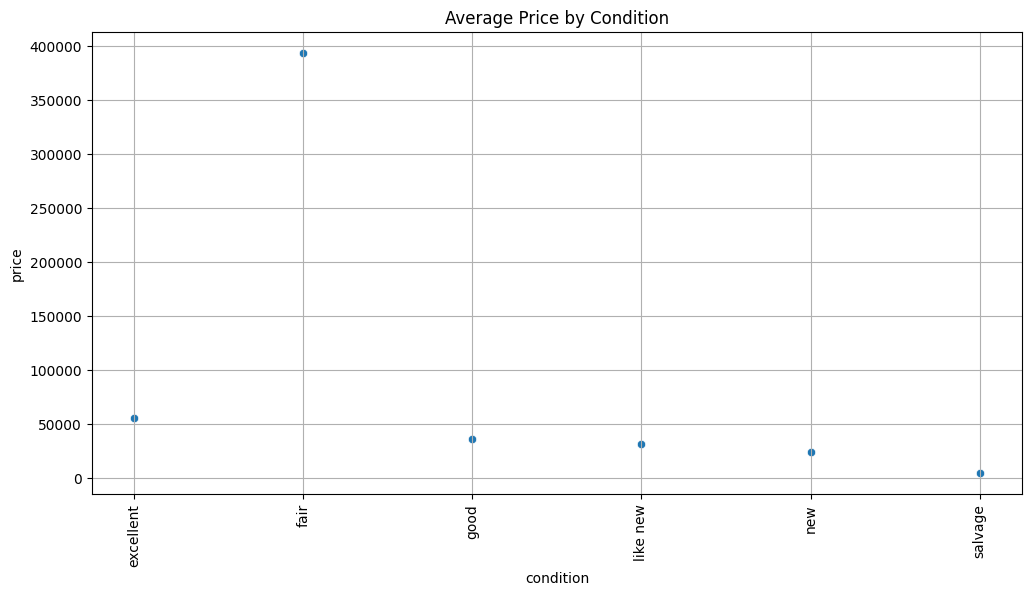

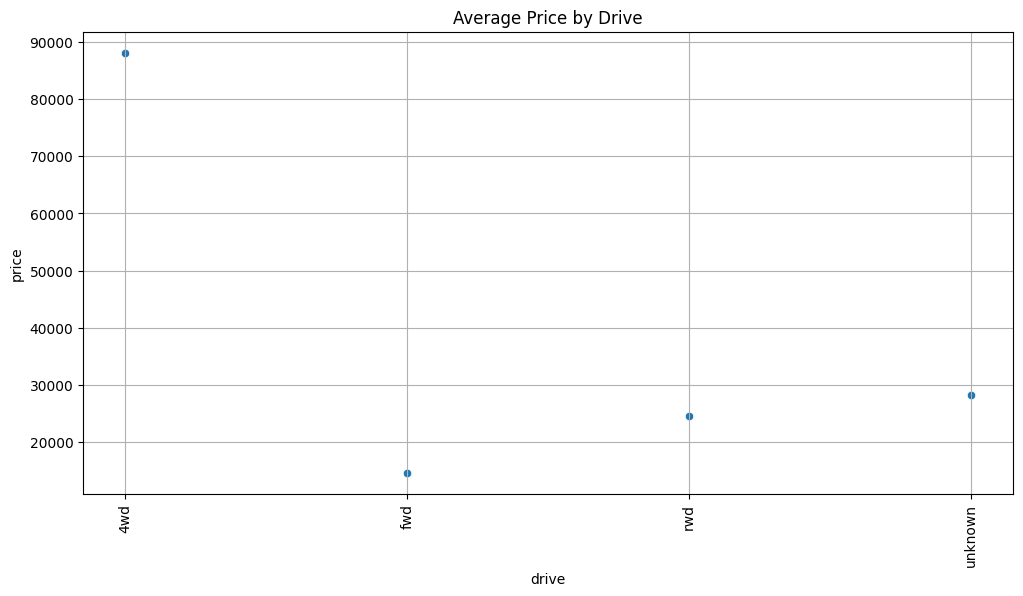

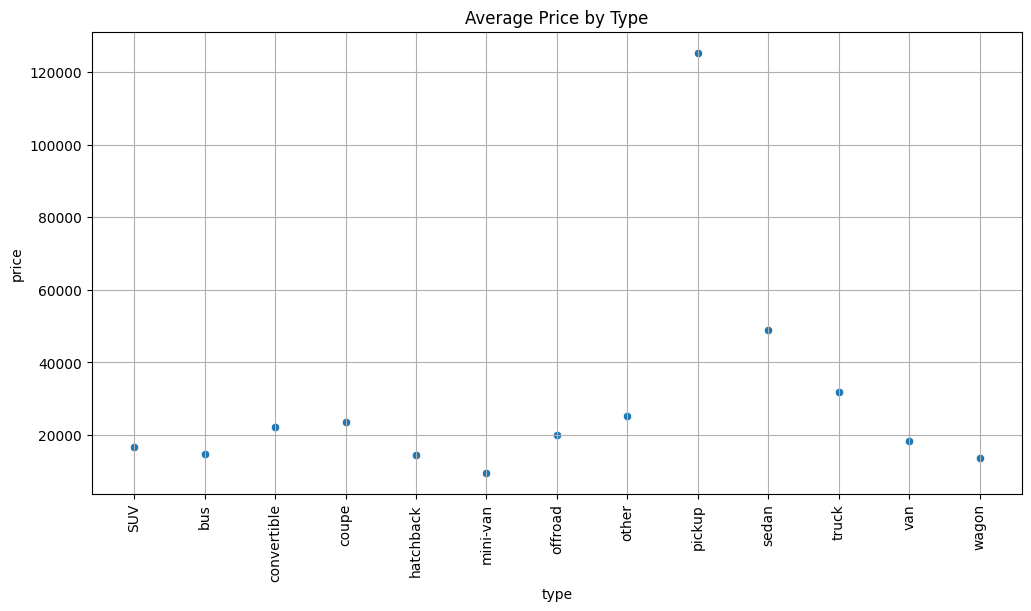

In [35]:
#Creating scatter plot on the raw data with the features which have been dropped for further analysis
vehicle_df_scat = vehicle_df.copy()
vehicle_df_scat.fillna({
    'year': vehicle_df['year'].median(),
    'manufacturer': vehicle_df['manufacturer'].mode()[0],
    'model': 'unknown',
    'condition': vehicle_df['condition'].mode()[0],
    'cylinders': vehicle_df['cylinders'].mode()[0],
    'fuel': vehicle_df['fuel'].mode()[0],
    'odometer': vehicle_df['odometer'].median(),
    'title_status': vehicle_df['title_status'].mode()[0],
    'transmission': vehicle_df['transmission'].mode()[0],
    'drive': 'unknown',
    'type': vehicle_df['type'].mode()[0],
    'paint_color': vehicle_df['paint_color'].mode()[0],
}, inplace=True)
vehicle_df_scat = vehicle_df_scat[vehicle_df_scat['year'] >= 2003]
vehicle_df_scat = vehicle_df_scat.dropna(subset=['price'])

# Aggregate data by manufacturer and model
agg_condition = vehicle_df_scat.groupby('condition')['price'].mean().reset_index()
agg_drive = vehicle_df_scat.groupby('drive')['price'].mean().reset_index()
agg_type = vehicle_df_scat.groupby('type')['price'].mean().reset_index()

# Plot aggregated data
plt.figure(figsize=(12, 6))
sns.scatterplot(data=agg_condition, x='condition', y='price')
plt.title('Average Price by Condition')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/condition.png')
plt.show()

# Plot aggregated data
plt.figure(figsize=(12, 6))
sns.scatterplot(data=agg_drive, x='drive', y='price')
plt.title('Average Price by Drive')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/drive.png')
plt.show()

# Plot aggregated data
plt.figure(figsize=(12, 6))
sns.scatterplot(data=agg_type, x='type', y='price')
plt.title('Average Price by Type')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/type.png')
plt.show()


## Observations from the above Scatter Plots
**Condition**: Prices generally decrease as the condition worsens, with new and like-new vehicles priced higher than those in fair or salvage condition.

**Drive**: Four-wheel drive vehicles command the highest prices, followed by front-wheel and rear-wheel drive vehicles.

**Type**: Pickup trucks and SUVs tend to have higher average prices, whereas hatchbacks, buses, and vans are priced lower on average.

# Data Preparation

In [6]:
# Drop non-interesting features, filtering rows with nulls
drop_columns = ['id', 'region',  'condition', 'drive',
                'size', 'type', 'paint_color', 'title_status', 'VIN',
                 'state']
vehicle_df_filtered = vehicle_df.drop(drop_columns, axis=1).dropna().reset_index(drop=True)
vehicle_df_filtered.shape



(234270, 8)

In [5]:
vehicle_df_filtered.isnull().sum()

price           0
year            0
manufacturer    0
model           0
cylinders       0
fuel            0
odometer        0
transmission    0
dtype: int64

In [ ]:
vehicle_df_filtered.head(5)

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission
0,33590,2014.0,gmc,sierra 1500 crew cab slt,8 cylinders,gas,57923.0,other
1,22590,2010.0,chevrolet,silverado 1500,8 cylinders,gas,71229.0,other
2,39590,2020.0,chevrolet,silverado 1500 crew,8 cylinders,gas,19160.0,other
3,30990,2017.0,toyota,tundra double cab sr,8 cylinders,gas,41124.0,other
4,15000,2013.0,ford,f-150 xlt,6 cylinders,gas,128000.0,automatic


In [ ]:
vehicle_df_filtered.describe()

,price,year,odometer
count,2.342700e+05,234270.000000,2.342700e+05
mean,5.492244e+04,2010.747125,1.032303e+05
std,1.116684e+07,8.958721,1.963414e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.555000e+03,2008.000000,4.726700e+04
50%,1.200000e+04,2013.000000,9.431350e+04
75%,2.499000e+04,2016.000000,1.398552e+05
max,3.736929e+09,2022.000000,1.000000e+07


In [ ]:
#Check percentiles 5%, 10% and 90%, 95%
vehicle_df_filtered.describe(percentiles = [.05,.1, .9,.95])

,price,year,odometer
count,2.342700e+05,234270.000000,2.342700e+05
mean,5.492244e+04,2010.747125,1.032303e+05
std,1.116684e+07,8.958721,1.963414e+05
min,0.000000e+00,1900.000000,0.000000e+00
5%,0.000000e+00,1998.000000,1.049600e+04
10%,1.250000e+03,2003.000000,2.059990e+04
50%,1.200000e+04,2013.000000,9.431350e+04
90%,3.649000e+04,2018.000000,1.812510e+05
95%,4.199755e+04,2019.000000,2.080404e+05
max,3.736929e+09,2022.000000,1.000000e+07


In [7]:
# Manual filter: price (upper (10%) and lower (95%)), year (upper 10%) and odometer (lower 90%)
vehicle_df_filtered = vehicle_df_filtered[(vehicle_df_filtered['price'] >= 1250.00) & (vehicle_df_filtered['price'] < 41997.55) & (vehicle_df_filtered['year'] >= 2003) & (vehicle_df_filtered['odometer'] <= 208040.4)]
vehicle_df_filtered.shape

(170548, 8)

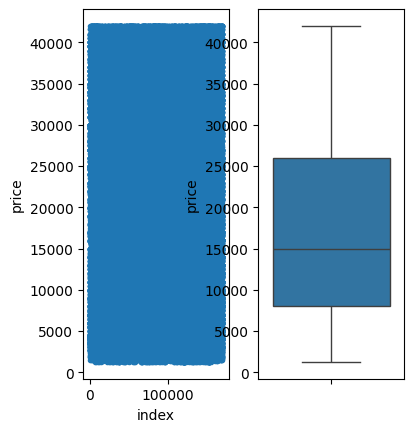

In [ ]:
# Boxplot drawing
y = np.array(vehicle_df_filtered.price)
plt.subplot(131)
plt.plot(range(len(y)),y,'.');plt.ylabel('price');plt.xlabel('index');
plt.subplot(132)
sns.boxplot(y=vehicle_df_filtered.price)
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/boxplot.png')
plt.show()

## Observations from the boxplot:
**Central Tendency**: The median price is around $15,000

**Spread:**
The prices are spread out from approximately 7000 (25th percentile) to 23000 (75th percentile), indicating that most vehicle prices fall within this range

**Symmetry:**
The box plot appears to be relatively symmetrical, suggesting that the vehicle prices are evenly distributed around the median

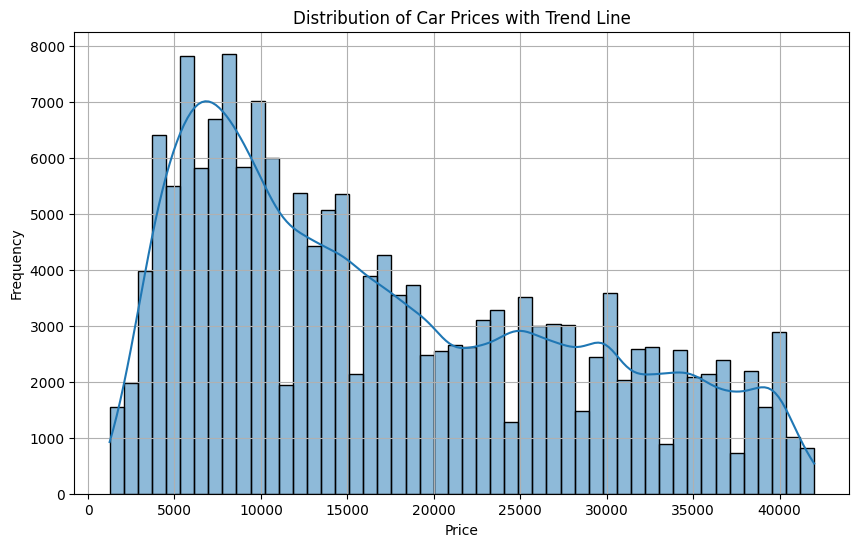

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(vehicle_df_filtered['price'], bins=50, kde=True, edgecolor='black')

plt.title('Distribution of Car Prices with Trend Line')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/histplot.png')
plt.show()

## Observation from the Histogram
**Central Tendency:** Most vehicles are priced around 8,000 to 10,000

**Distribution Shape:** The distribution is right-skewed, with the majority of prices on the lower end and a long tail towards higher prices.

**Spread and Clusters**
While there is a broad spread of prices, there are clusters of frequencies at certain price points up to $40,000

In [ ]:
#Determinining the price and odometer skewness
#import scipy.stats as stats
from scipy.stats import skew

price_skewness = skew(vehicle_df_filtered['price'])
print(f"Price skewness: {price_skewness}")
odometer_skewness = skew(vehicle_df_filtered['odometer'])
print(f"Odometer skewness: {odometer_skewness}")
#skew > 0 means positive skew which means the right tail is longer as we see in the plot

Price skewness: 0.5537869664203928
Odometer skewness: 0.11514313191071493


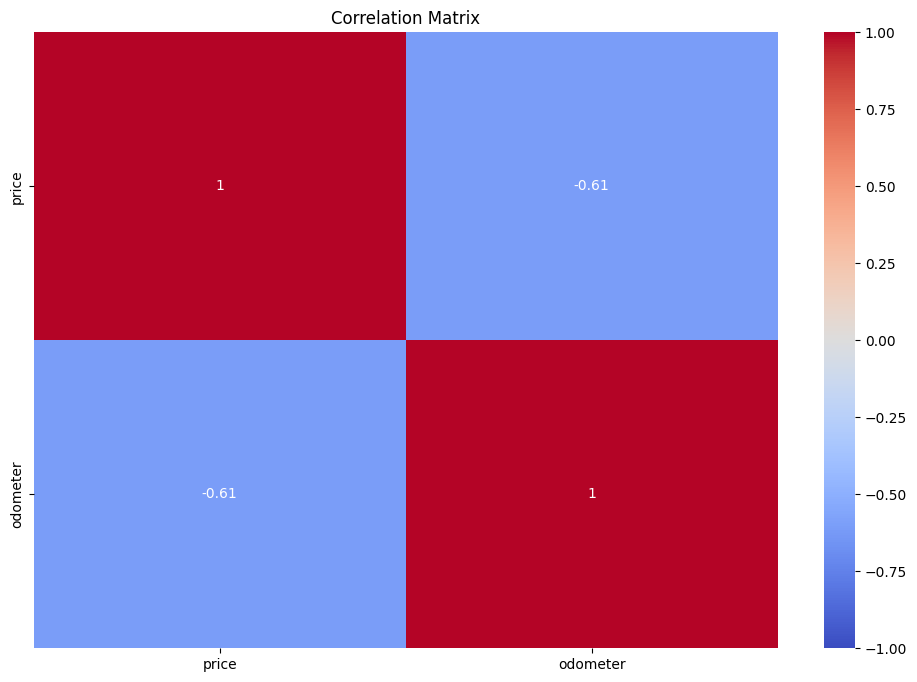

In [ ]:
#get all numeric columns for correlation matrix

correlation_matrix = vehicle_df_filtered[['price', 'odometer']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/correlation_matrix.png')
plt.show()
#There are very few numeric columns hence the correlation matrix in this case does not provide any useful info

## Observations from Correlation matrix

**Moderate to Strong Negative Correlation:**

The correlation coefficient between price and odometer is -0.61. This suggests that as the odometer reading (mileage) increases, the price of the vehicle tends to decrease.
This negative correlation is expected in the automotive market because vehicles with higher mileage are generally perceived as having more wear and tear, reducing their market value.

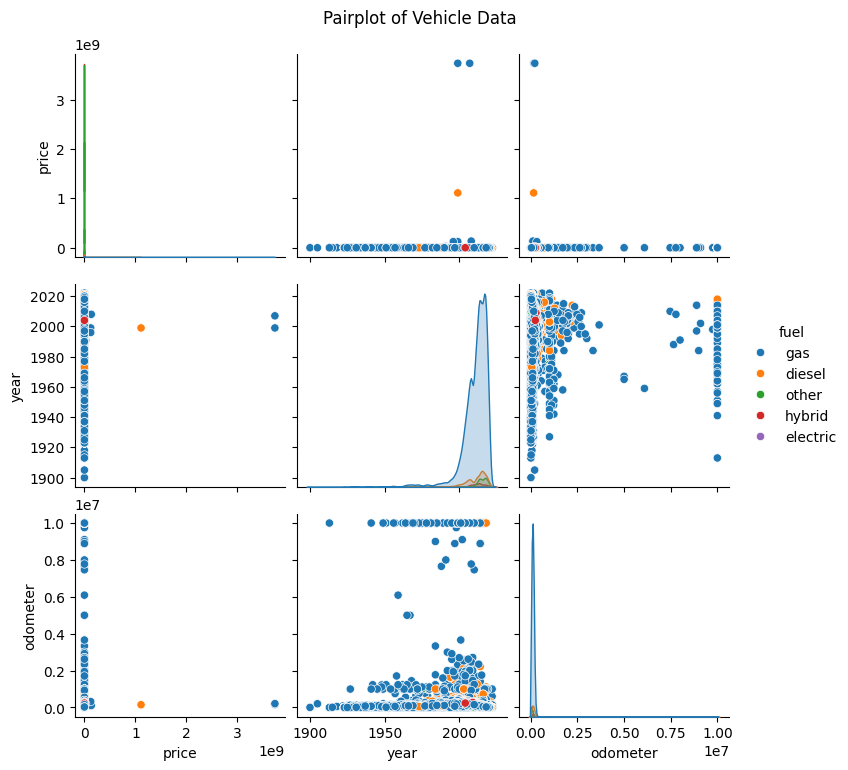

In [10]:
# Select a subset of columns for the pairplot to avoid overcrowding
subset_cols = ['price', 'year', 'odometer','fuel']

# Draw the pairplot
sns.pairplot(vehicle_df_filtered[subset_cols], hue='fuel')
plt.suptitle('Pairplot of Vehicle Data', y=1.02)
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/pairplot.png')
plt.show()

## Observations from the PairPlot

**Price** is negatively correlated with odometer and positively correlated with year

**Year** is negatively correlated with odometer

The **fuel** type differentiation shows that gas vehicles are most common, with a few outliers in other fuel types

**Outliers**: There are significant outliers, especially in the price and odometer variables, which may need further investigation.

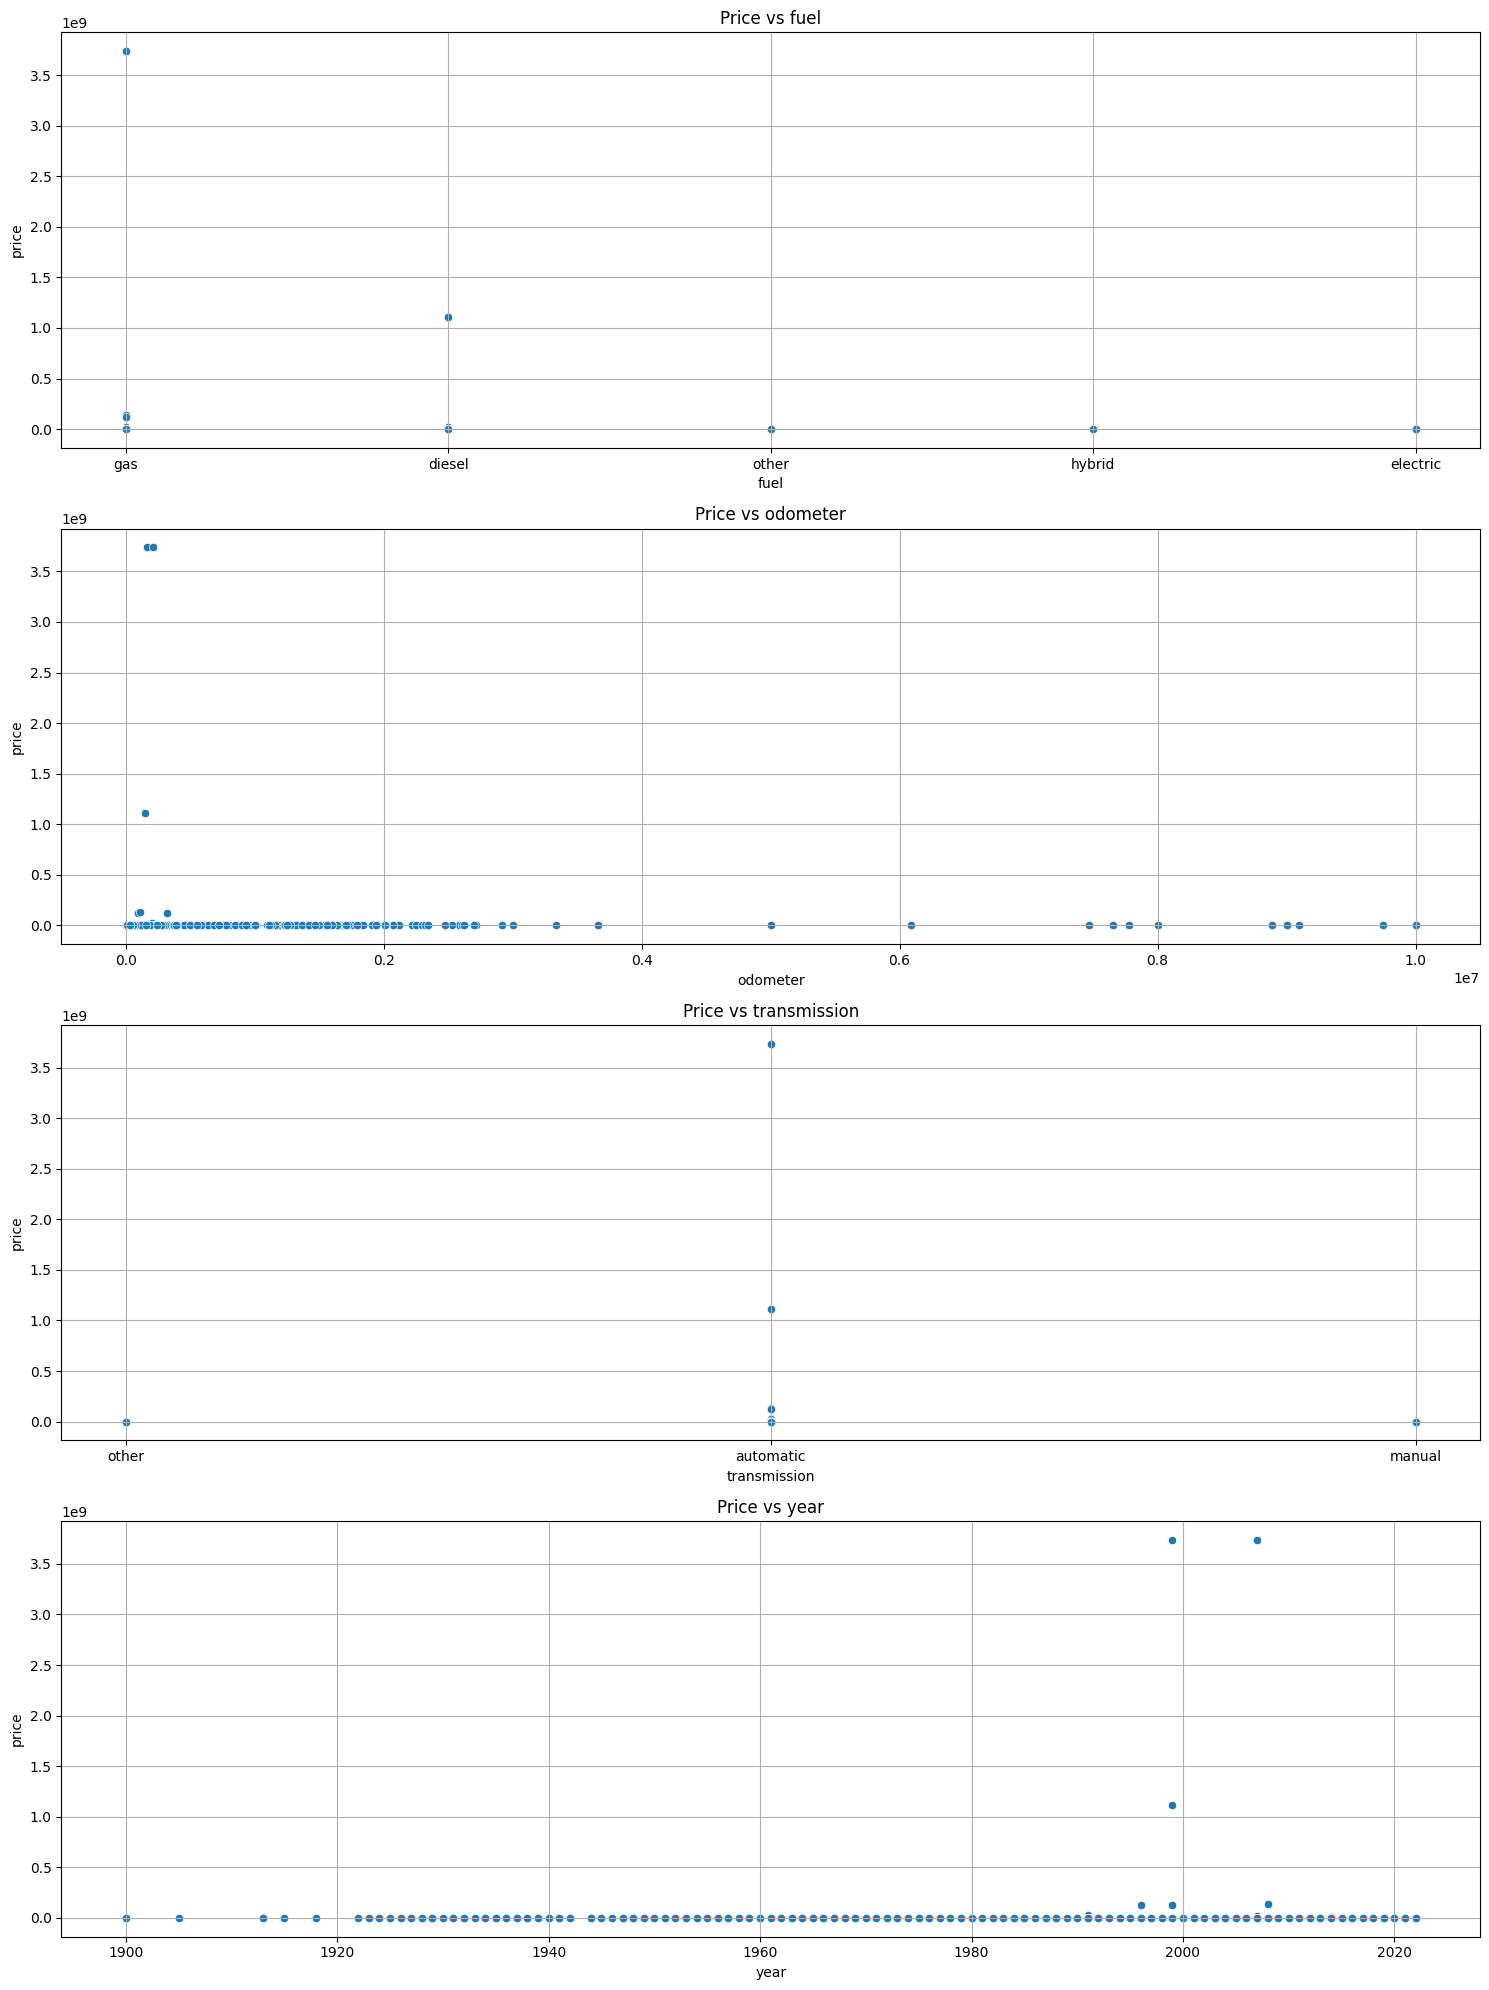

In [36]:
# Generate scatter plots
x_vars = vehicle_df_filtered.columns.difference(['price','model','manufacturer','cylinders'])  # all columns except 'price'
num_plots = len(x_vars)

plt.figure(figsize=(15, num_plots * 5))

for i, var in enumerate(x_vars):
    plt.subplot(num_plots, 1, i + 1)
    sns.scatterplot(data=vehicle_df_filtered, x=var, y='price')
    plt.title(f'Price vs {var}')
    plt.grid(True)

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/model_manu_cyl_scatterplot.png')
plt.show()

## Observations from the above Scatter Plots

**Fuel Type**: Gas vehicles dominate the dataset, but outliers suggest potential data errors with extremely high prices. Diesel, hybrid, and electric vehicles are less common but show varied prices

**Odometer**: Vehicles with lower mileage generally have higher prices, confirming that lower usage is associated with higher value

**Transmission**: Automatic transmission is the most common, with some high-priced outliers. Manual transmission vehicles tend to be lower-priced

**Year**: There is a clear trend of newer vehicles having higher prices, with older vehicles being significantly cheaper

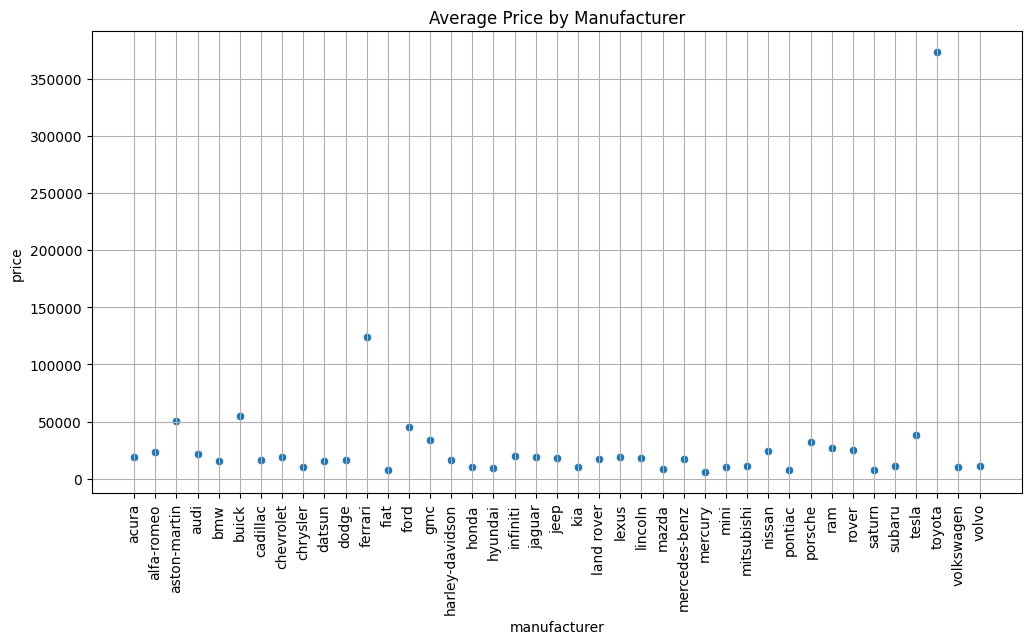

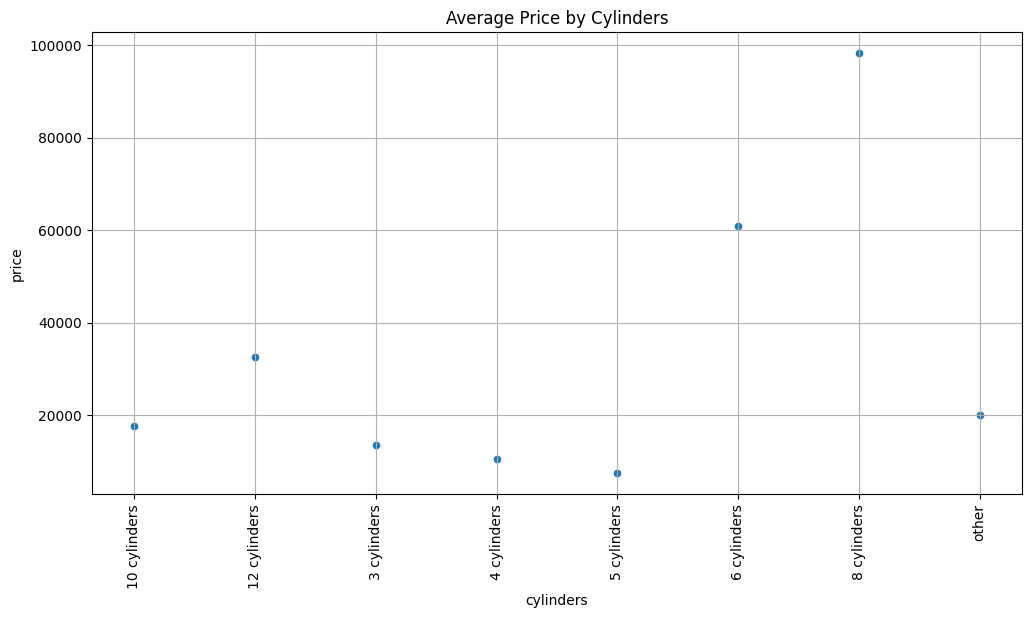

In [37]:
# Aggregate data by manufacturer and model
agg_manufacturer = vehicle_df_filtered.groupby('manufacturer')['price'].mean().reset_index()
agg_model = vehicle_df_filtered.groupby('model')['price'].mean().reset_index()
agg_cylinders = vehicle_df_filtered.groupby('cylinders')['price'].mean().reset_index()

# Plot aggregated data
plt.figure(figsize=(12, 6))
sns.scatterplot(data=agg_manufacturer, x='manufacturer', y='price')
plt.title('Average Price by Manufacturer')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/manufacturer.png')
plt.show()

# Plot aggregated data
plt.figure(figsize=(12, 6))
sns.scatterplot(data=agg_cylinders, x='cylinders', y='price')
plt.title('Average Price by Cylinders')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/cylinders.png')
plt.show()


## Observations from the above Scatter Plots
**Cylinders**: There is a clear trend of increasing average vehicle price with the number of cylinders. This reflects the association of more cylinders with higher performance and luxury vehicles

**Manufacturer**: Luxury and high-performance brands such as Ferrari, Porsche, and Tesla command the highest average prices. Mainstream brands like Toyota and Ford have lower average prices, reflecting a broader market appeal and a mix of economy and mid-range vehicles.

## Feature Engineering, Splitting Data into Train and Test Data

In [8]:
#Separate numeric and categorical variables
numeric_cols = vehicle_df_filtered.select_dtypes(include=['int64','float64']).columns
categorical_cols= vehicle_df_filtered.select_dtypes(include=['object']).columns

In [9]:
# Remove 'price' from numeric_col if it exists
# Handling categorical attributes using One-Hot-Encoder
# Feature Scaling for numeric variables using StandardScaler
numeric_col_1 = numeric_cols.tolist()
if 'price' in numeric_cols:
    numeric_col_1.remove('price')
#print(numeric_col_1)
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_col_1),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])
print(preprocessor)
print(categorical_cols)

ColumnTransformer(transformers=[('num', StandardScaler(), ['year', 'odometer']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['manufacturer', 'model', 'cylinders', 'fuel', 'transmission'], dtype='object'))])
Index(['manufacturer', 'model', 'cylinders', 'fuel', 'transmission'], dtype='object')


In [10]:
# Splitting into Train and Test data
X = vehicle_df_filtered.drop('price', axis=1)
y = vehicle_df_filtered['price']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Apply preprocessing to the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_preprocessed)
X_test_df = pd.DataFrame.sparse.from_spmatrix(X_test_preprocessed)
print(X_train_preprocessed.shape)
print(X_test_preprocessed.shape )
print(X_train_df.shape)
print(X_test_df.shape)
# Get the feature names after preprocessing
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_col_1, encoded_feature_names])
print(all_feature_names)

(136438, 11131)
(34110, 11131)
(136438, 11131)
(34110, 11131)
['year' 'odometer' 'manufacturer_acura' ... 'transmission_automatic'
 'transmission_manual' 'transmission_other']


# Machine Learning Modelling - Regression

In [ ]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}


In [ ]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

Linear Regression: RMSE = 3849.5081, R2 = 0.8740
Ridge Regression: RMSE = 3832.3144, R2 = 0.8751
Lasso Regression: RMSE = 4555.6888, R2 = 0.8235


**Ridge Regression model**
seems to be performing the best. It has the lowest **RMSE** and the highest **R2** value. It is the most suitable model for this dataset based on the given metrics.

## Cross Validation and Hyperparameter Tuning

In [12]:
# Perform cross-validation and hyperparameter tuning
# Define the parameter grid for Ridge, Lasso
# Lasso took a very long time before aborting, hence removed Lasso

param_grid = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0]}
}
#'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0]}
#removed Lasso - taking too long and disconnecting
# Initialize the models

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge()
}
#'Lasso': Lasso()

best_models = {}
for name, model in models.items():
    if name in param_grid:
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error')
        grid.fit(X_train_preprocessed, y_train)
        best_models[name] = grid.best_estimator_
        best_rmse = np.sqrt(-grid.best_score_)
        print(f"Best {name}: {grid.best_params_}, RMSE = {best_rmse:.4f}")
    else:
        # For Linear Regression, just perform cross-validation
        scores = cross_val_score(model, X_train_preprocessed, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)  # Convert negative MSE to RMSE
        best_models[name] = model
        print(f"{name}: Cross-validation RMSE = {rmse_scores.mean():.4f}")



Linear Regression: Cross-validation RMSE = 3875.0813
Best Ridge: {'alpha': 0.1}, RMSE = 3825.8728


In [13]:
best_models

{'Linear Regression': LinearRegression(), 'Ridge': Ridge(alpha=0.1)}

In [14]:
#Evaluate the best models on the test set
print('Evaluate the best models on the test set')
results = {}
for name, model in best_models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

Evaluate the best models on the test set
Linear Regression: RMSE = 3849.5081, R2 = 0.8740
Ridge: RMSE = 3814.3201, R2 = 0.8763


In [15]:
# Use the best Ridge model to make predictions
best_ridge_model = best_models['Ridge']
y_pred = best_ridge_model.predict(X_test_preprocessed)

# Create a DataFrame to show actual vs. predicted values
actual_vs_predicted_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
actual_vs_predicted_df.head()

,Actual,Predicted
15864,36590,36611.897254
126555,26990,26979.535718
86942,12995,11801.478934
72395,5495,13899.169166
55183,11799,16148.977390


In [ ]:
# Get the coefficients and the intercept from the best Lasso model
#X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_preprocessed)
#selected_features = X_train_df.columns[selector.get_support()]
#print(selected_features)
best_ridge_model = best_models['Ridge']
coefficients = pd.Series(best_ridge_model.coef_, index=X_train_df.columns)
intercept = best_ridge_model.intercept_

print("Ridge Regression Coefficients:")
print(coefficients)
print("\nIntercept:", intercept)

Ridge Regression Coefficients:
0        5206.346336
1       -2685.857380
2        -380.211993
3        3874.200477
4       -1934.663121
            ...     
11126    -850.334208
11127   -1102.813110
11128    -576.871447
11129     219.109498
11130     357.762601
Length: 11131, dtype: float64

Intercept: 19166.76297735399


## Interpretation of the coefficients and the intercept
**Intercept** = 19166.76297735399 means when all the other variables have a value of 0 (which is not practical), the price of a car would be approximately $19,167

**Coefficients** - represent change in the target variable (which in this case is price), with the change in 1 unit of one predictor variable assuming all other predictor variables are held constant. Given the large number of features (11131 coefficients), it's not possible to interpret each one individually without knowing the feature names

**Positive Coefficients:** A positive coefficient means that as the value of the feature increases, the price also increases. For example, a coefficient of 5206.35 for a feature means that for every one-unit increase in this feature, the price increases by $5206.35, all else being equal

**Negative Coefficients**: A negative coefficient means that as the value of the feature increases, the price decreases. For example, a coefficient of -2685.86 means that for every one-unit increase in this feature, the price decreases by $2685.86, all else being equal.


## Sequential Feature Selection using SFS

In [ ]:
#this process ran for 2hr 25 mins and then aborted, hence could not run the feature selector
# Define the Ridge regression model
ridge = Ridge()

# Define the preprocessing and model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sfs', SFS(ridge, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=5)),
    ('model', ridge)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get the selected features
selected_features = pipeline.named_steps['sfs'].k_feature_names_
selected_feature_names = [all_feature_names[int(i[1:])] for i in selected_features]

# Refit the Ridge model with selected features
X_train_selected = pipeline.named_steps['sfs'].transform(X_train)
ridge.fit(X_train_selected, y_train)

# Get coefficients and intercept
coefficients = pd.Series(ridge.coef_, index=selected_feature_names)
intercept = ridge.intercept_

print("Ridge Regression Coefficients:")
print(coefficients)
print("\nIntercept:", intercept)

In [ ]:
#Ran for 2 hr 42 mins and then disconnected, hence could not run the feature selector
# Define the Linear Regression model
linear_reg = LinearRegression()

# Define the preprocessing and model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sfs', SFS(linear_reg, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=5)),
    ('model', linear_reg)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get the selected features
selected_features = pipeline.named_steps['sfs'].k_feature_names_
selected_feature_names = [all_feature_names[int(i[1:])] for i in selected_features]

# Refit the Linear Regression model with selected features
X_train_selected = pipeline.named_steps['sfs'].transform(X_train)
linear_reg.fit(X_train_selected, y_train)

# Get coefficients and intercept
coefficients = pd.Series(linear_reg.coef_, index=selected_feature_names)
intercept = linear_reg.intercept_

print("Linear Regression Coefficients:")
print(coefficients)
print("\nIntercept:", intercept)

### Evaluation




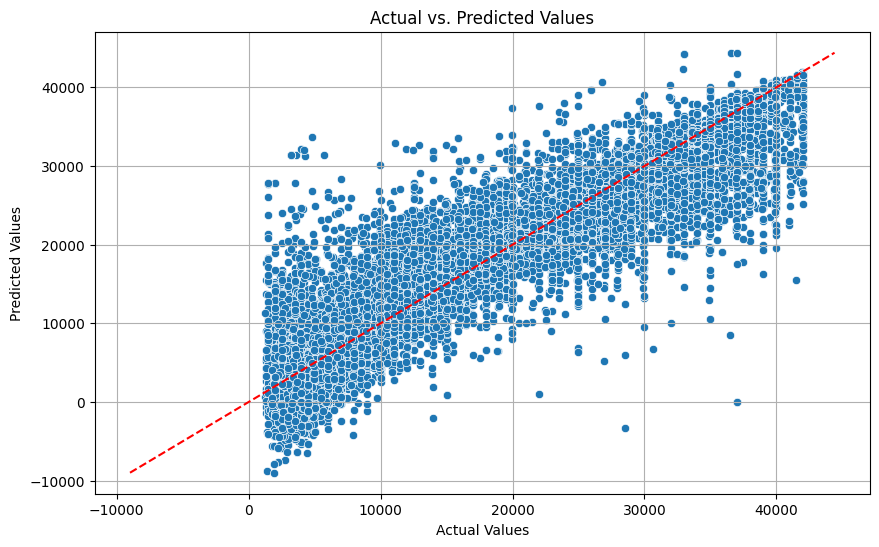

In [17]:
# Scatter plot of actual versus predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=actual_vs_predicted_df)
plt.plot([actual_vs_predicted_df.min().min(), actual_vs_predicted_df.max().max()],
         [actual_vs_predicted_df.min().min(), actual_vs_predicted_df.max().max()],
         color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/practical_application_II_starter/images/actual_vs_predicted.png')
plt.show()

## Interpretation of the Actual vs Predicted price
**Diagonal Reference Line:**

The red dashed line represents the ideal scenario where the predicted values perfectly match the actual values. Points on this line indicate perfect predictions

**Distribution of Points:**The points are generally spread around the diagonal line, indicating that the model's predictions are reasonably close to the actual values
However, there is noticeable scatter, which suggests that there is variability in the predictions

**Prediction Accuracy:**

**Positive Predictions:** Most of the points lie in the first quadrant (both actual and predicted values are positive), indicating that the model generally predicts positive prices

**Negative Predictions:** There are some negative predicted values (below the x-axis), which are not practical in the context of vehicle prices. This suggests that the model has some errors, potentially due to outliers or extreme values in the dataset

**High Prices:** For higher actual prices (above $30,000), the predictions tend to be less accurate, with points scattered more widely. This indicates that the model struggles to predict high vehicle prices accurately


## Conclusions

### Business Understanding Recap
The data set contains 426K records of car details. The goal of this exercise is to use predictive modelling to predict what drives the price of a used car. The understanding of what features are important for consumers will be benefitial for used car dealers to drive up their sales.

## Findings
**Condition**: Prices generally decrease as the condition worsens, with new and like-new vehicles priced higher than those in fair or salvage condition.

**Drive**: Four-wheel drive vehicles command the highest prices, followed by front-wheel and rear-wheel drive vehicles.

**Type**: Pickup trucks and SUVs tend to have higher average prices, whereas hatchbacks, buses, and vans are priced lower on average.
Central Tendency: The median price is around $15,000

**Odometer**: Vehicles with lower mileage generally have higher prices, confirming that lower usage is associated with higher value

**Fuel Type**: Gas vehicles dominate the dataset. Diesel, hybrid, and electric vehicles are less common but show varied prices

**Transmission**: Automatic transmission is the most common, manual transmission vehicles tend to be lower-priced

**Year**: There is a clear trend of newer vehicles having higher prices, with older vehicles being significantly cheaper

**Cylinders**: There is a clear trend of increasing average vehicle price with the number of cylinders. This reflects the association of more cylinders with higher performance and luxury vehicles

**Manufacturer**: Luxury and high-performance brands such as Ferrari, Porsche, and Tesla command the highest average prices. Mainstream brands like Toyota and Ford have lower average prices, reflecting a broader market appeal and a mix of economy and mid-range vehicles

**Outliers**: There are significant outliers, as seen from the Actual versus Predicted plot, which may need further investigation.
Also the RMSE derived for Ridge and Linear regression are not particularly good and might benefit from feature selection

The disadvantage of this dataset was, due to a large number of categorical variables, it takes too long to train a model, do Grid search or feature selection.











.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.